In [1043]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


Best guess response: 58


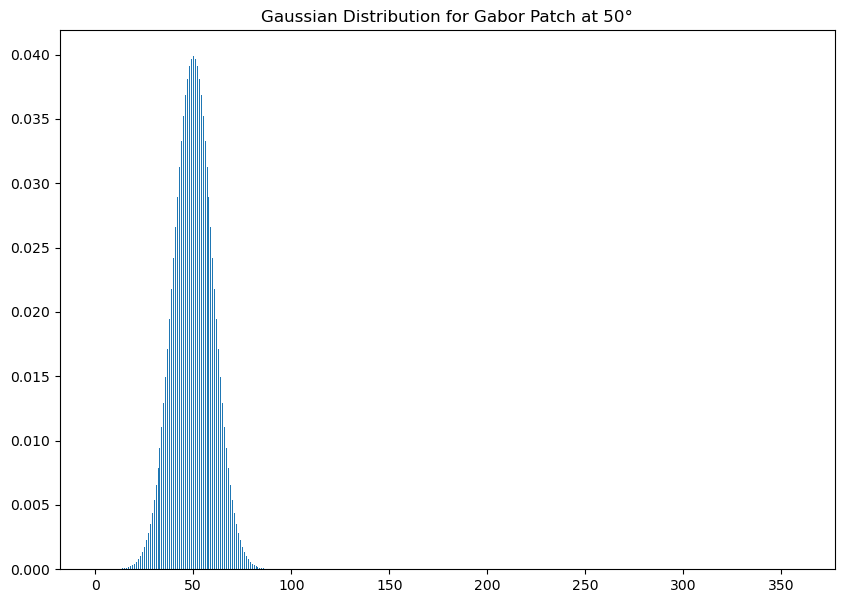

In [1044]:
"""
Want to make a way to create a poisson distribution for each gabor patch, each representing a population of neurons
so depending on the orientation of the patch, there will be a different distribution, shifted by the orientation of the patch
Let's say since we go by degrees, we'll have 360 neurons, each having a perferred orientation difference of 1 degrees
The population coding model that I want to use comes from the step of neural decoding,
So a Poisson distribution that has the same variance each time won't work
I think we can use a couple of different tiers of neuron populations, each with a different variance
lets say that we have 3 tiers of neurons, each with a different variance
There are the highly tuned neurons, which have a low variance, and are very sensitive to the orientation of the patch
These will only be used on the middle of the texture, the innermost 3rd of the texture
Then there are the moderately tuned neurons, which have a medium variance, and are sensitive to the orientation of the patch
These will be used on the middle 3rd of the texture
Finally, there are the broadly tuned neurons, which have a high variance, and are not very sensitive to the orientation of the patch
These will be used on the outer 3rd of the texture
ideally this will reflect the visual actuity that this present when looking at the texture
Additionally, let us pick our variances from 3 ranges, so that while we will still have low, medium, and high variance,
we will have a range of variances within each category so they aren't all the same
"""
def create_neuronal_response_gaussian_distribution(preferred_orientation, num_neurons, variance_value):
    """
    Create a Poisson-like (Gaussian-shaped) distribution for a population of neurons.

    Parameters:
    preferred_orientation (float): Mean of the distribution, representing the stimulus orientation.
    num_neurons (int): Number of neurons in the population.
    variance (str): 'low', 'medium', or 'high' to select variance range.

    Returns:
    np.ndarray: the distribution across all neurons.
    """
    
    # if variance == 'low':
    #     variance_value = np.random.uniform(15, 20)  # Low variance range
    # elif variance == 'medium':
    #     variance_value = np.random.uniform(20, 30)  # Medium variance range
    # elif variance == 'high':
    #     variance_value = np.random.uniform(30, 40)  # High variance range
    # else:
    #     raise ValueError("Variance must be 'low', 'medium', or 'high'.")

    orientations = np.linspace(0, 360, num_neurons, endpoint=False)
    # Gaussian-shaped tuning curve (not a true Poisson, but as described in your docstring)
    gaussian_distribution = (1 / np.sqrt(2 * np.pi * (variance_value ** 2))) * \
        np.exp(-((orientations - preferred_orientation) ** 2) / (2 * (variance_value ** 2)))
    gaussian_distribution /= np.sum(gaussian_distribution)  # Normalize the distribution
    return gaussian_distribution
distribution = create_neuronal_response_gaussian_distribution(preferred_orientation=50, num_neurons=360, variance_value=10)
plt.figure(figsize=(10, 7))
plt.bar(np.linspace(0, 360, 360, endpoint=False), distribution, width=.5)
plt.title('Gaussian Distribution for Gabor Patch at 50°')
def create_gabor_neuron_distribution(orientation, num_neurons=36):
    """
    Create a Poisson distribution for a Gabor patch based on its orientation.
    
    Parameters:
    orientation (float): Orientation of the Gabor patch in degrees.
    num_neurons (int): Number of neurons in the population.
    
    Returns:
    np.ndarray: Poisson distribution for the Gabor patch.
    """
    # Convert orientation to radians
    orientation_rad = np.deg2rad(orientation)
    
    # Create an array of preferred orientations for each neuron
    preferred_orientations = np.linspace(0, 2 * np.pi, num_neurons, endpoint=False)
    
    # Calculate the difference from the preferred orientation
    differences = preferred_orientations - orientation_rad
    
    # Calculate the Poisson distribution based on the differences
    gaussian_distribution = np.exp(-np.abs(differences))
    
    return gaussian_distribution

#Next we want to get the best guess response of the neurons based on the Poisson distribution
#The guess response is selected by chance depending on the distribution's probability density
#so if the distribution is high at a specific value, it will be more likely to select a response close to that value.

def get_best_guess_response(distribution):
    """
    Get the best guess response based on the Poisson distribution.
    
    Parameters:
    distribution (np.ndarray): Poisson distribution for the Gabor patch.
    
    Returns:
    int: Index of the best guess response.
    """    
    # Select a response based on the distribution
    best_guess_response = np.random.choice(len(distribution), p=distribution)
    
    return best_guess_response

print("Best guess response:", get_best_guess_response(distribution))



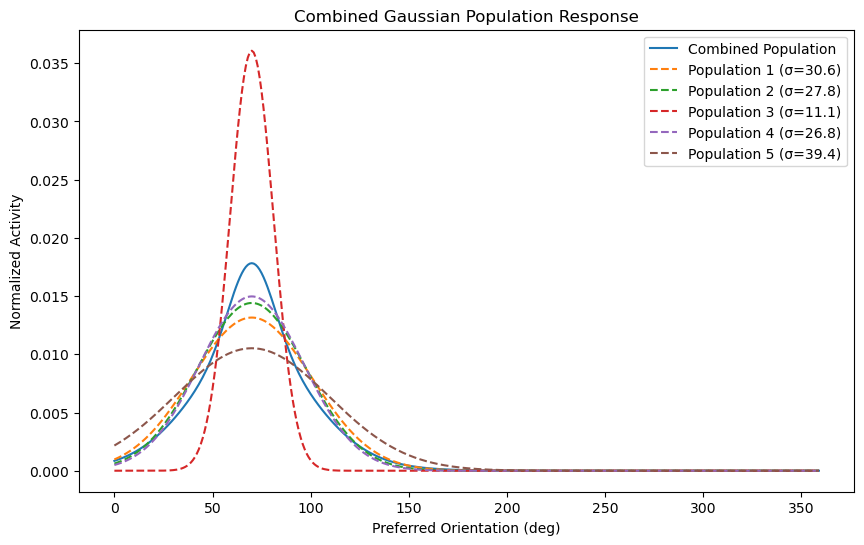

In [1045]:

def create_gaussian_population(preferred_orientation, num_neurons, num_populations, std_range):
    """
    Create and combine multiple Gaussian neuronal populations with random standard deviations.

    Parameters:
    preferred_orientation (float): Center of the Gaussian (stimulus orientation).
    num_neurons (int): Number of neurons (bins) per population.
    num_populations (int): Number of populations to combine.
    std_range (tuple): (min_std, max_std) for random standard deviation.

    Returns:
    np.ndarray: Combined population response.
    """
    orientations = np.linspace(0, 360, num_neurons, endpoint=False)
    combined_response = np.zeros(num_neurons)
    stds = []

    for _ in range(num_populations):
        std = np.random.uniform(*std_range)
        stds.append(std)
        gaussian = np.exp(-0.5 * ((orientations - preferred_orientation) / std) ** 2)
        gaussian /= gaussian.sum()  # Normalize each population
        combined_response += gaussian

    combined_response /= num_populations  # Optional: average the populations
    return orientations, combined_response, stds

# Example usage
preferred_orientation = 70
num_neurons = 360
num_populations = 5
std_range = (10, 40)  # Simulate a range of sensitivities

orientations, combined_response, stds = create_gaussian_population(
    preferred_orientation, num_neurons, num_populations, std_range
)

plt.figure(figsize=(10, 6))
plt.plot(orientations, combined_response, label='Combined Population')
for i, std in enumerate(stds):
    plt.plot(
        orientations,
        np.exp(-0.5 * ((orientations - preferred_orientation) / std) ** 2) / np.exp(-0.5 * ((orientations - preferred_orientation) / std) ** 2).sum(),
        '--',
        label=f'Population {i+1} (σ={std:.1f})'
    )
plt.title('Combined Gaussian Population Response')
plt.xlabel('Preferred Orientation (deg)')
plt.ylabel('Normalized Activity')
plt.legend()
plt.show()

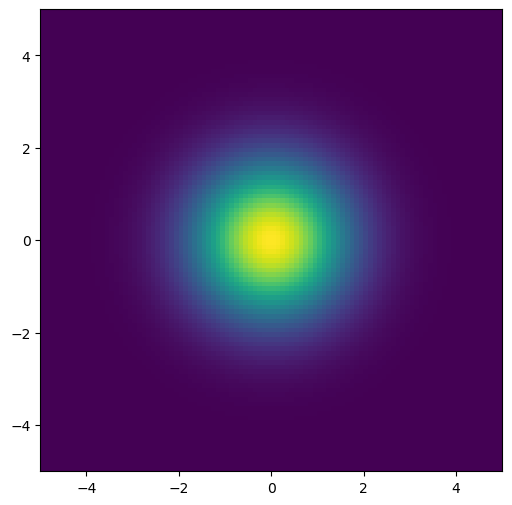

In [1046]:
dims = [-3,3,100]
x = np.linspace(dims[0], dims[1], dims[2])
y = np.linspace(dims[0], dims[1], dims[2])
X, Y = np.meshgrid(x, y)
Gi = np.exp(-(X**2 + Y**2))
plt.figure(figsize=(8, 6))
plt.imshow(Gi, extent=(-5, 5, -5, 5), origin='lower', cmap='viridis')

In [1047]:
# Signal and Noise angle generation
signal_angle = [-45, 45]  # only these 2 as it is a 2AFC task
noise_angle = np.random.normal(0, 30, 4)  # Generate noise angles with a mean of 0 and std deviation of 30


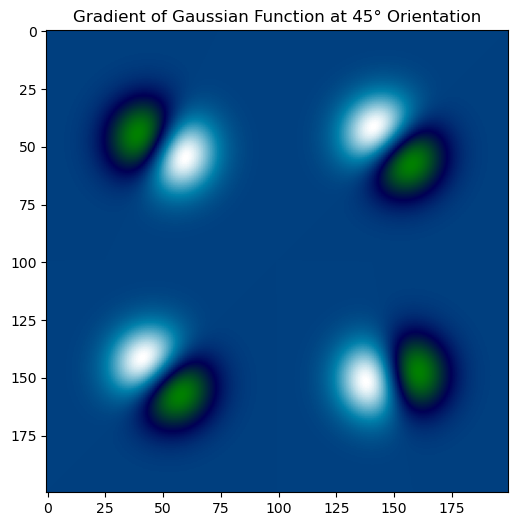

In [1048]:
GiPrimex = -2 * X * Gi
GiPrimey = -2 * Y * Gi
math_angle = 45
perceived_angle = -math_angle + 90
theta = np.deg2rad(math_angle)  # Example orientation in radians
GiPrimeTheta11 = np.cos(noise_angle[0])*GiPrimex + np.sin(noise_angle[0])*GiPrimey
GiPrimeTheta21 = np.cos(theta)*GiPrimex + np.sin(theta)*GiPrimey
GiPrimeTheta22 = np.cos(noise_angle[1])*GiPrimex + np.sin(noise_angle[1])*GiPrimey
GiPrimeTheta12 = np.cos(theta)*GiPrimex + np.sin(theta)*GiPrimey
GiPrimeTheta1 = np.concatenate((GiPrimeTheta11, GiPrimeTheta12),axis=1)
GiPrimeTheta2 = np.concatenate((GiPrimeTheta21, GiPrimeTheta22),axis=1)
GiPrimeTheta = np.concatenate((GiPrimeTheta1, GiPrimeTheta2), axis=0)
plt.figure(figsize=(8, 6))
plt.imshow(GiPrimeTheta, cmap='ocean')
plt.title(f'Gradient of Gaussian Function at {math_angle}° Orientation')
plt.show()


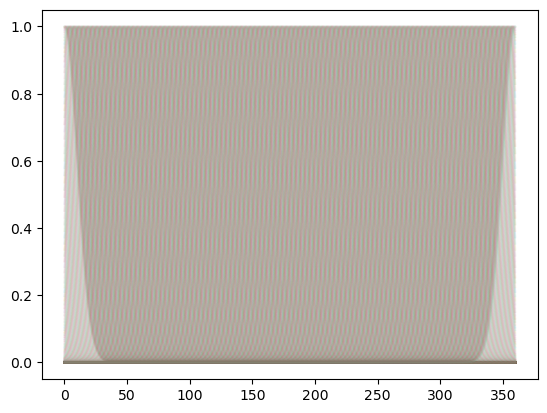

In [1049]:
# In order to take advantage of the Wei Ji Ma Baysian inference model, we need i number of neurons, and as the resolution of the funtion increase 
# with the number of neurons, lets do 1000 to 
# First we need a gaussian tuning curve
import numpy as np
x = np.linspace(0, 360, 1000)  # how many points are in the tuning curve 
mu = np.linspace(0, 360, 1000)  # 1000 different preferred orientations
sigma = 10  # Standard deviation for each of the Gaussian tuning curves
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)
# Do not normalize the gaussian, if it is normalized, given that it is discontinuous, for neurons near the ends of the sample, the probability will be skewed toward those ends
for mu_value in mu:
    plt.plot(x, gaussian(x, mu_value, sigma), alpha=0.1)  # Plot each Gaussian with low opacity 


# Now let's define our poisson distribution function 
def poisson(k, lam):
    return (lam**k * np.exp(-lam)) / np.math.factorial(k)
# For our neurons, k will be the number of spikes, and lam will be the mean firing rate
# so we will feed the gaussian to the poisson, 





# neurons = {
# 'neuron0TC'   : np.random.normal(loc=0, scale=40, size=1000),  # Neuron with preferred orientation 0° 
# 'neuron90TC'  : np.random.normal(loc=90, scale=40, size=1000),  # Neuron with preferred orientation 90°
# 'neuron270TC' : np.random.normal(loc=270, scale=40, size=1000),  # Neuron with preferred orientation -90°
# 'neuron180TC ': np.random.normal(loc=180, scale=40, size=1000),  # Neuron with preferred orientation 180°
# }

# for i in neurons:
#     #for j in range(100):
#     plt.hist(neurons[i], bins=100, alpha=0.5, label=i)
# plt.title('Histograms of Neuronal Responses')


    


